# Deep Learning - Exercise 2

This lecture is about introduction to using ANN for regression tasks.

We will use our models on [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset.

This dataset contains fule consumptions of several vehicles in miles per gallon. So, we need to predict the fuel efficiencies of various vehicles from the data that has been provided.

**Core Concepts**
* ⛽ Regression task of predicting fuel consumption
* 💾 Auto MPG dataset from UCI Machine Learning Repository
* 🚗 Predicting fuel efficiency of vehicles
* 🧪 Using provided data to train ANN regression models

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

tf.version.VERSION

'2.18.0'

In [2]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [4]:
def show_history_loss(history):
    plt.figure()
    for key in history.history.keys():
        if 'loss' not in key:
            continue
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## 🤔 Questions to explore before we dive in!

1️⃣ **Regression vs Classification**
* What is the key difference between predicting a continuous value vs assigning a category?
 * Regression predicts continuous values, while classification assigns discrete categories.
* Can you think of real examples where regression would be more appropriate than classification?
  * Predicting house prices *(regression)* vs classifying spam emails *(classification)*.

2️⃣ **Solving Regression Tasks**
* What steps would you include in your ML pipeline for regression?
  * Data preprocessing, feature engineering, model selection, training, evaluation.
* Which model architecture would you choose and why?
  * Depends on data—linear regression for simple trends, neural networks for complex patterns.
* How would you measure if your predictions are good?
  * Metrics like MAE, MSE, RMSE, or R².

3️⃣ **ANN vs Linear Regression**
* What makes neural networks more powerful than simple linear models?
  * ANNs capture complex, non-linear relationships; linear models only fit straight-line trends.
* When would the added complexity of an ANN be worth it?
  * When data has high dimensionality or non-linear patterns.


# Load the dataset first

## Dataset info
* Number of Instances: 398
* Number of Attributes: 9 including the class attribute

**Attribute Information:**

| # | Feature | Type | Description |
|---|---------|------|-------------|
| 1 | mpg | continuous | Miles per gallon (higher = better) |
| 2 | cylinders | discrete | Number of engine cylinders |
| 3 | displacement | continuous | Engine displacement volume |
| 4 | horsepower | continuous | Engine power output |
| 5 | weight | continuous | Vehicle weight |
| 6 | acceleration | continuous | Time to accelerate 0-60 mph |
| 7 | model year | discrete | Year of manufacture |
| 8 | origin | discrete | Manufacturing region |
| 9 | car name | string | Unique vehicle identifier |


* Missing Attribute Values:  horsepower has 6 missing values

In [5]:
url = 'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/auto-mpg.csv'
rel_path = 'datasets/auto-mpg.csv'
df = pd.read_csv(url, na_values='?', sep=';')

In [6]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


## Check missing values

In [7]:
df.isna().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
car_name,0


## 📊 Exploring the Data Visually

Let's analyze our dataset through these key questions:

1. 🤔 Which row/columns carry the most significance and why?

2. 🔍 Can you spot the categorical features from these visualizations?
   * Look for discrete values
   * Check for non-numeric patterns

3. 📏 Numeric Features Analysis:
   * Are the scales consistent across features?
   * How might different ranges impact our model?

4. 🔗 Feature Relationships:
   * Look for potential correlations
   * Identify possible colinear features

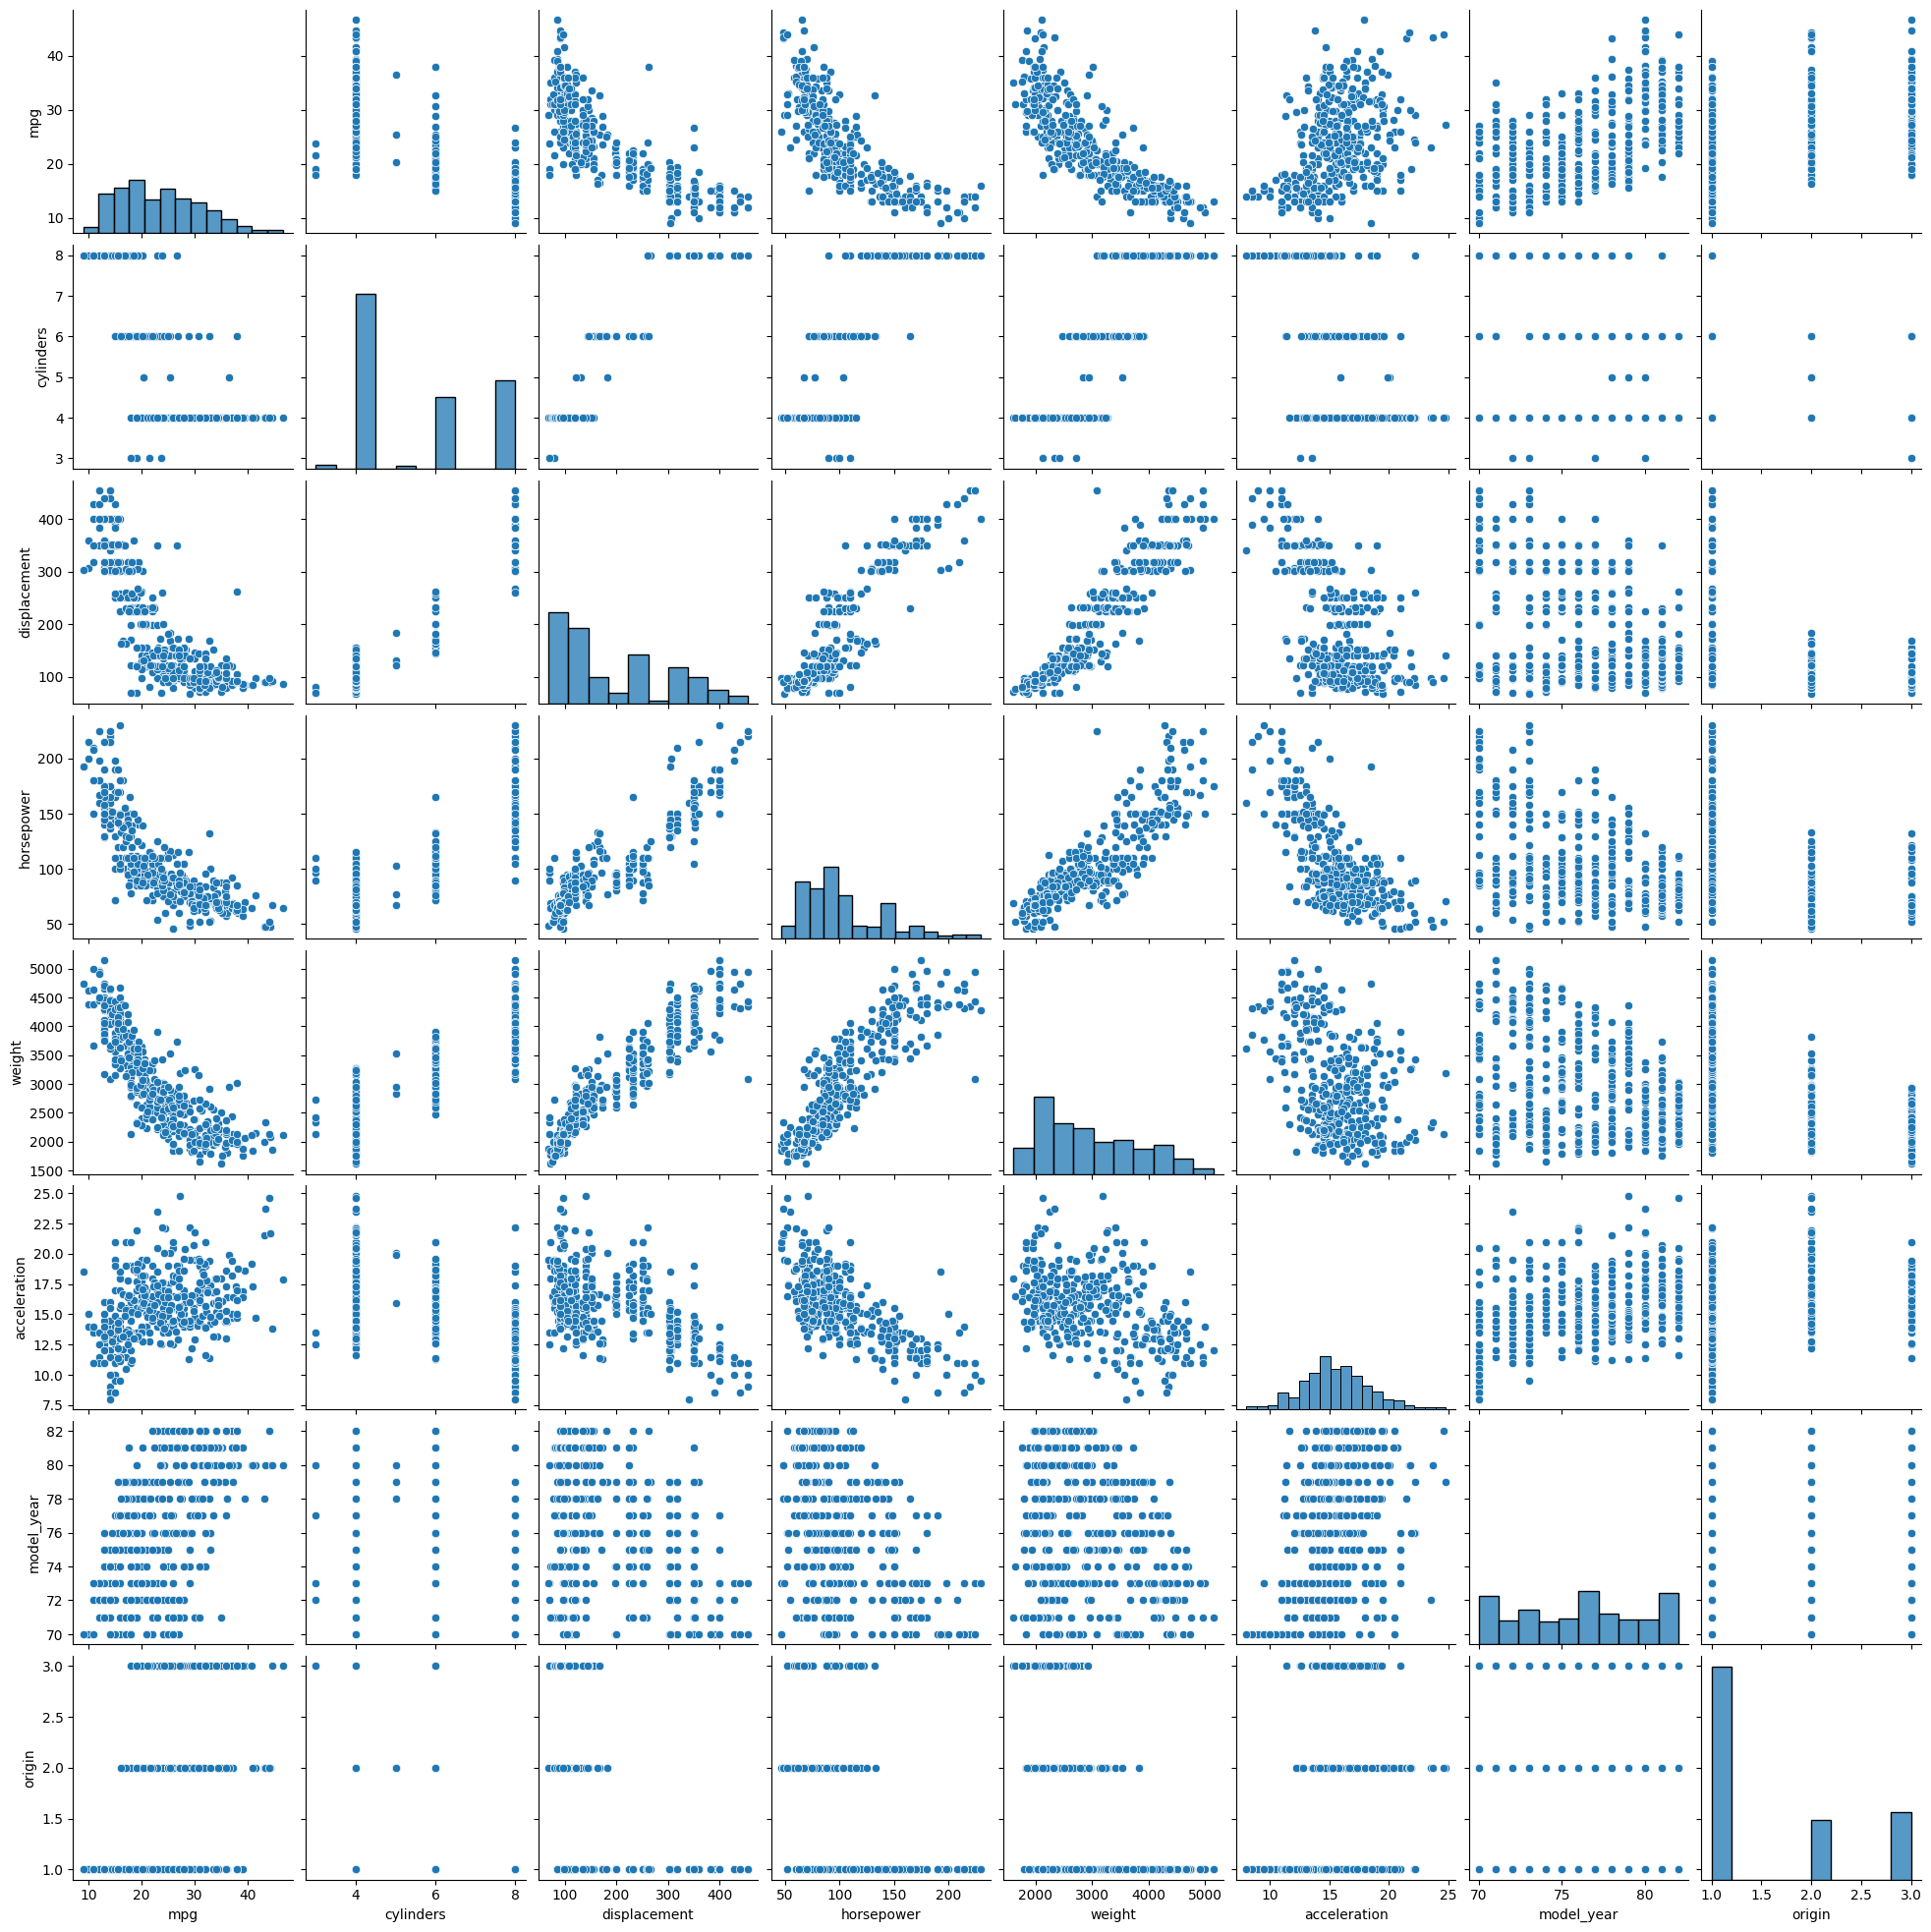

In [8]:
sns.pairplot(df)

## Do you see any colinearity in the data?
* Can it cause any issue? How to deal with it?
  * Correlated features keeps the information the same for increased dimensionality cost
  * Solutions: Remove one of the correlated variables, Use Principal Component Analysis (PCA), Apply regularization techniques (Ridge or Lasso Regression), Calculate and remove variables with high Variance Inflation Factor (VIF)

<Axes: >

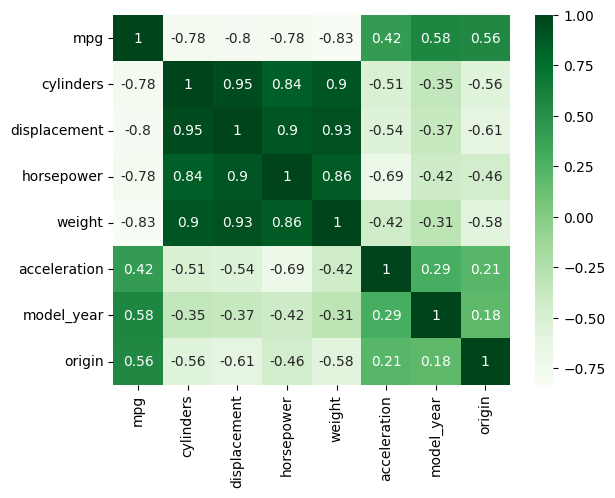

In [9]:
sns.heatmap(df.corr(numeric_only=True), cmap='Greens', annot=True)

## We can plot the categorical data using boxplots
* Beware that the data are about cars from 80s, we won't see many 6 or 8 cylinder cars nowadays

<Axes: xlabel='cylinders', ylabel='mpg'>

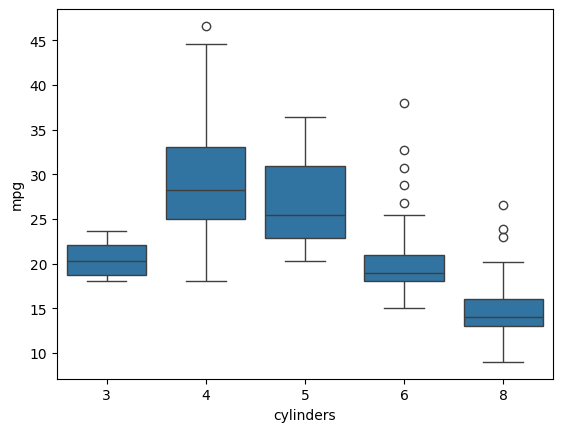

In [10]:
sns.boxplot(data = df, x='cylinders', y='mpg')

<Axes: xlabel='origin', ylabel='mpg'>

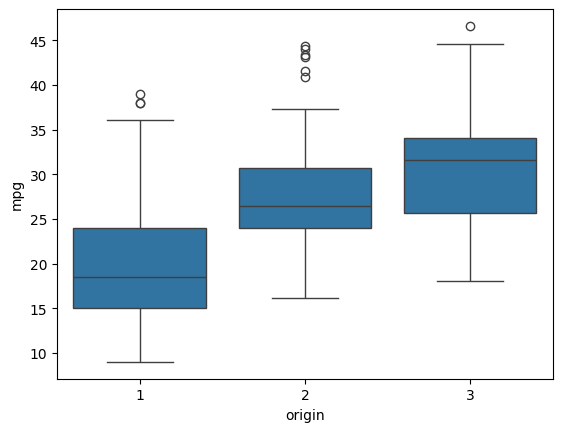

In [11]:
sns.boxplot(data = df, x='origin', y='mpg')

## 💡 There is no info about the *origin* feature = detective work incoming 🙂

### What do you think that the origin means based on the printed data?
* And what car origin is your favourite? 🙂

In [12]:
df.loc[df.origin == 1, 'car_name']

,car_name
0,chevrolet chevelle malibu
1,buick skylark 320
2,plymouth satellite
3,amc rebel sst
4,ford torino
...,...
392,chevrolet camaro
393,ford mustang gl
395,dodge rampage
396,ford ranger


In [13]:
df.loc[df.origin == 2, 'car_name']

,car_name
19,volkswagen 1131 deluxe sedan
20,peugeot 504
21,audi 100 ls
22,saab 99e
23,bmw 2002
...,...
354,renault 18i
359,peugeot 505s turbo diesel
360,volvo diesel
375,volkswagen rabbit l


In [14]:
df.loc[df.origin == 3, 'car_name']

,car_name
14,toyota corona mark ii
18,datsun pl510
29,datsun pl510
31,toyota corona
53,toyota corolla 1200
...,...
382,toyota corolla
383,honda civic
384,honda civic (auto)
385,datsun 310 gx


## Okay, now we have the basic understanding of the data we can start to try some models
* We need to deal with the NA values first, as is it just a few rows, we will drop the data

In [15]:
df = df.loc[~df.horsepower.isna(), :].copy()

## 🏷️ Handling Categorical Features

Let's examine our categorical variables:

### Origin Feature 🌍
* Even though *origin* appears numerical (1, 2, 3)
* These numbers are actually codes representing:
  * 1 → American
  * 2 → European
  * 3 → Asian
* ⚠️ Why treat as categorical? Numbers don't represent order or magnitude!
  * origin is categorical because numbers (1, 2, 3) are codes for regions (1 → American, 2 → European, 3 → Asian).
  * Catch: Numbers don't imply order or magnitude.

### Car Name Feature 🚗
* Text data that needs encoding
* Contains brand/model information

❓ Key Question:
* Why is *origin* categorical despite being numerical? What's the catch?
  * origin is categorical because the numbers are codes for different categories, not implying order or magnitude. Treating them as numerical would mislead the model.

### car_name is problematic beacause we have quite a few brands so one-hot encoding would add too many columns
* We will drop the feature

In [16]:
df['car_name'].apply(lambda x: x.split(' ')[0]).value_counts()

,count
car_name,
ford,48
chevrolet,43
plymouth,31
dodge,28
amc,27
toyota,25
datsun,23
buick,17
pontiac,16


In [17]:
df = df.drop('car_name', axis=1)

In [18]:
df['origin'] = df['origin'].replace({1: 'USA', 2: 'EUR', 3: 'JAP'})

In [19]:
df = pd.get_dummies(df, columns=['origin'], prefix=['origin_'])

In [20]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin__EUR,origin__JAP,origin__USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False,True


## Split the data into input and output part

In [21]:
X, y = df.drop('mpg', axis=1), df.mpg

In [22]:
X.shape, y.shape

((392, 9), (392,))

## Do the train/test in ratio 80:20

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 9), (79, 9), (313,), (79,))

## 🎯 Creating Baseline Model

We'll start with Linear Regression as our foundation:

### Linear Regression vs ANN 🤔
* Linear regression:
  * Simple mathematical formula
  * Clear coefficients for each feature
  * Direct feature importance interpretation

* Neural Network:
  * Complex layered structure
  * Hidden transformations
  * "Black box" nature

❓ Key Question:
* Which model provides better explainability - ANN or Linear Regression? Why?
* Linear Regression:  
    * Simple mathematical formula
    * Clear, interpretable coefficients
    * Direct feature importance
* ANN:  
    * Complex structure
    * Hidden transformations
    * "Black box" nature
    
Linear Regression is more explainable due to its simplicity and clear coefficients.

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_01.jpg?raw=true)

## We will use just *horsepower* and *model_year* features because the high correlation values

In [25]:
alg = LinearRegression()
alg.fit(X_train.loc[:, ['horsepower', 'model_year']], y_train)
y_pred = alg.predict(X_test.loc[:, ['horsepower', 'model_year']])

## 📊 Model Evaluation in Regression

### Common Regression Metrics 📏

1. Basic Metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Square Error)

2. Advanced Metrics:
* R² (R-squared)
* MAPE (Mean Absolute Percentage Error)
* sMAPE (Symmetric MAPE)

❓ Key Question:
* Can you write mathematical formulas for any of these metrics?
  * Think about:
    * Actual values (y)
    * Predicted values (ŷ)
    * Number of samples (n)

💡 Note: I've prepared evaluation functions to help you calculate all metrics easily!

In [26]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,3.941482,23.74165,19.133313,19.846932,0.581278


# Now we can create our first deep learning model and compare it to the baseline
* The ANN model can use more features as it is designed for bigger datasets and multicolinearity is not so big issue as in the LR case
* We will start with a raw data
* The evaluation step is the same

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_04.jpg?raw=true)

## 🔎 Why do we use *linear* activation in the output layer?

# 📒 NOTE for Task 2: This is the benchmark model

In [27]:
(X_train.shape[1],)

(9,)

In [28]:
inp = keras.layers.Input(shape=(X_train.shape[1],))

hidden_1 = keras.layers.Dense(128, activation='relu')(inp)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='linear')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [29]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5320.2959 - mean_absolute_error: 49.4283 - mean_absolute_percentage_error: 244.8610 - val_loss: 6192.5269 - val_mean_absolute_error: 72.1909 - val_mean_absolute_percentage_error: 378.9958
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3016.2397 - mean_absolute_error: 40.6190 - mean_absolute_percentage_error: 213.7672 - val_loss: 1212.7273 - val_mean_absolute_error: 29.7076 - val_mean_absolute_percentage_error: 163.1725
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3164.9458 - mean_absolute_error: 42.5143 - mean_absolute_percentage_error: 226.1566 - val_loss: 147.2083 - val_mean_absolute_error: 10.3248 - val_mean_absolute_percentage_error: 52.1011
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1616.7209 - mean_absolute_error: 30.7415 - mean_absolute_percentage_error: 157.8513 - val_loss: 123.8753 - val_mean_absolute_error: 9.4559 - val_mean_absolute_percentage_error: 46.8304
Epoch 5/100
32/3

## 📈 Comparing Model Metrics

### Model Comparison 🔄
* Compare metrics between:
  * Linear Regression
  * Our Neural Network

❓ Key Questions:
* Is the model performing better? Why?
  * Compare the MAE, MSE, and R2 scores of both models. The model with lower MAE and MSE and higher R2 is performing better.
  * The performance difference can be due to the complexity of the models. Neural Networks can capture more complex patterns compared to Linear Regression.
* What's the purpose of .ravel()?
  * Hint: Think about array dimensions!
  * **.ravel()** transforms multi-dimensional arrays into 1D arrays, which is often required for metric calculations. This ensures that the predictions and true values have the same shape for comparison.

💡 Note: .ravel() transforms multi-dimensional arrays into 1D arrays, which is often required for metric calculations.

In [30]:
model.load_weights("best.weights.h5")

y_pred = model.predict(X_test).ravel()

df_pred_origin = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred_origin)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,3.012321,16.065327,13.708837,13.80333,0.716662


## It is very good practice to check the loss function values of train/validation data during the training and not only the metrics
* Do you see any issue with the val_loss?
  - regularization error - depends on data input, batch_size, optimizer and learning rate

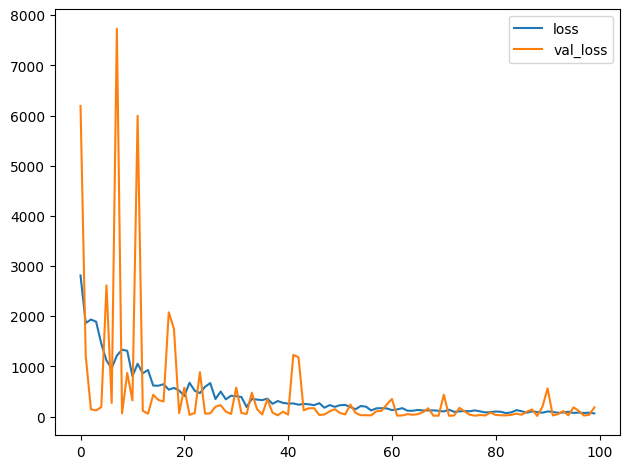

In [31]:
show_history_loss(history)

## The loss function plot show clear instability of learning
* This is a big issue in the regression tasks and it is pretty common one
* It is caused by the features magnitude differences
* We can solve the matter with feature scaling (normalization)
* A https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization layer can be used for solving the matter

### Why is magnitude difference an issue?

* You can see that the gradient of the slope is orders of magnitude larger than the intercept.

![Grad01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_noscale.png?raw=true)

* If we take a look at the one optimization step values change you can see that only the slope changed in value (we see a vertical line in the plot above, with no change in the intercept parameter).
    * That’s because the slope gradient is way bigger than the intercept gradient.
    * Gradient actually points in the direction of steepest ascent.
    * Gradient is the vector of all partial derivatives of the loss function with respect to all the model weights.
        * **Basically these values will tell you in which direction (+ or - delta) and how much you should change the individual weights values to lower the loss function value**
        * The amount we adjust our slope each iteration is controlled by a *learning rate* parameter
    
![Grad02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_noscale_grad.png?raw=true)

### There are a few ways we can solve our problem above. The most common way is to simply scale your features before gradient descent.

![Grad03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_scale.png?raw=true)

* We can see that not the optimization process is not stuck and computed gradients in the individual steps points in the right direction.

![Grad04](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_scale_grad.png?raw=true)


* **I recommend visiting https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter1_gradient-descent.html for more details about the topic**

## 🔄 Data Normalization

### Why Normalize? 🎯
* Neural networks are sensitive to input scales
* Features with different ranges can cause:
  * Slower convergence
  * Poor model performance
  * Training instability

### Process 🔧
1. Normalize features to similar ranges
2. Retrain the model
3. Compare results with previous version

❓ Key Questions:
* Will normalized data improve our model?
  * Normalized data can improve the model by ensuring that all features contribute equally to the learning process. This can lead to faster convergence, better performance, and more stable training.
* How will the metrics change?
  * Metrics such as accuracy, loss, and other evaluation metrics are likely to improve with normalized data. The model may achieve higher accuracy and lower loss values, indicating better performance and generalization.

In [32]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train.to_numpy())

## We can take a look at the mean and variance used in the normalization process for each feature

In [33]:
print('Mean: ', np.array(norm_layer.variables[0]))
print('Variance: ', np.array(norm_layer.variables[1]))

Mean:  [5.4217253e+00 1.9218690e+02 1.0329713e+02 2.9654761e+03 1.5636742e+01
 7.6105431e+01 1.7891374e-01 1.9169329e-01 6.2939298e-01]
Variance:  [2.9147997e+00 1.0745592e+04 1.4390651e+03 7.1411250e+05 7.6496086e+00
 1.3800385e+01 1.4690362e-01 1.5494697e-01 2.3325746e-01]


In [34]:
inp = keras.layers.Input(shape=(X_train.shape[1],))
norm = norm_layer(inp)
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='linear')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,460 (21.33 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 19 (80.00 B)

## Train the model

In [35]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 517.9814 - mean_absolute_error: 21.5201 - mean_absolute_percentage_error: 91.9202 - val_loss: 383.3317 - val_mean_absolute_error: 18.4194 - val_mean_absolute_percentage_error: 76.3104
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 319.2078 - mean_absolute_error: 16.3062 - mean_absolute_percentage_error: 66.9004 - val_loss: 166.1469 - val_mean_absolute_error: 11.6467 - val_mean_absolute_percentage_error: 47.3520
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 118.5102 - mean_absolute_error: 9.3170 - mean_absolute_percentage_error: 38.0359 - val_loss: 41.3407 - val_mean_absolute_error: 4.9875 - val_mean_absolute_percentage_error: 20.8646
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.5733 - mean_absolute_error: 4.4184 - mean_absolute_percentage_error: 20.0877 - val_loss: 15.5977 - val_mean_absolute_error: 2.9011 - val_mean_absolute_percentage_error: 12.5400
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━

In [36]:
model.load_weights("best.weights.h5")

y_pred = model.predict(X_test).ravel()

df_pred_origin_norm = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred_origin_norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,2.195392,9.970854,9.787748,9.631657,0.824148


## 👀 Analyzing the Impact of Normalization

### Before vs After Comparison 📊
* Training behavior
* Convergence speed
* Final metrics

### Why Normalization Matters 🎯
* Similar scales → Stable gradients
* Benefits:
  * ⚡ Faster convergence
  * 📈 Higher learning rates possible
  * 🎯 Better numerical stability

❓ Key Question:
* Do you notice any differences in model performance after normalization?
  * Yes, normalization typically leads to improved model performance. The key differences observed are: Training Behavior, Convergence Speed, Final Metrics

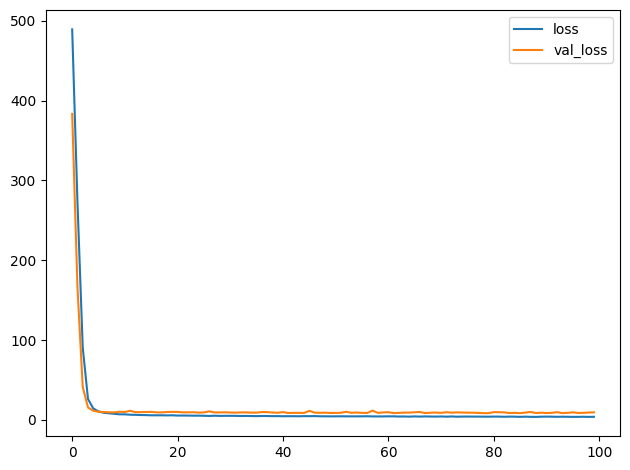

In [37]:
show_history_loss(history)

## We can transform the output as well
* There are multiple scaling options
    * MinMax, Std. scale, Log, BoxCox, ...
    
### We will test *MinMaxScaler* into (-1;1) range

In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()
y_test_scaled = scaler.transform(np.array(y_test).reshape((-1, 1))).ravel()

In [39]:
y_train_scaled[:10]

array([ 0.32978723, -0.04255319, -0.09574468, -0.44680851, -0.73404255,
       -0.12234043, -0.68085106, -0.30851064, -0.36170213, -0.38829787])

## ⚠️ Output Activation Function Warning

### The Activation Range Problem 🎯
* Sigmoid → [0,1] range only
* Can't produce negative values
* Real data may need wider range

❓ Key Question:
* What happens when activation function range doesn't match our target variable range?
  * Mismatch in activation and target ranges constrains predictions, causing inaccuracy.

💡 Remember: Always match your output activation to your target variable range!
* Linear → unbounded values
* ReLU → positive values
* Sigmoid → [0,1]
* Tanh → [-1,1]

### Anti-Pattern Example ☣️
* Using sigmoid for unbounded regression
* Model will be limited to positive values
* Can't predict full range of target variable

In [40]:
inp = keras.layers.Input(shape=(X_train.shape[1],))
norm = norm_layer(inp)
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='sigmoid')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,460 (21.33 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 19 (80.00 B)

## Train the model

In [41]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4006 - mean_absolute_error: 0.5536 - mean_absolute_percentage_error: 312.7456 - val_loss: 0.2177 - val_mean_absolute_error: 0.3955 - val_mean_absolute_percentage_error: 144.5608
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2274 - mean_absolute_error: 0.3962 - mean_absolute_percentage_error: 150.5036 - val_loss: 0.1946 - val_mean_absolute_error: 0.3684 - val_mean_absolute_percentage_error: 131.5068
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2233 - mean_absolute_error: 0.3924 - mean_absolute_percentage_error: 135.1118 - val_loss: 0.1895 - val_mean_absolute_error: 0.3623 - val_mean_absolute_percentage_error: 135.8959
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2086 - mean_absolute_error: 0.3724 - mean_absolute_percentage_error: 133.3889 - val_loss: 0.1867 - val_mean_absolute_error: 0.3544 - val_mean_absolute_percentage_error: 114.8899
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [42]:
model.load_weights("best.weights.h5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test_scaled, 'y_pred': y_pred})
compute_metrics(df_pred)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,0.389868,0.217136,90.278631,168.438846,-0.353514


## Now we can transfer the data back

In [43]:
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()
y_pred[:10]

array([27.8     , 27.800013, 27.8     , 27.8     , 27.82147 , 27.84116 ,
       27.973352, 33.29597 , 27.8     , 31.886904], dtype=float32)

In [44]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,7.32951,76.744615,43.361851,32.094664,-0.353514


## 📊 Analyzing Predictions vs Reality

### Spotting the Problem 🔍
* Predictions limited to [0,1] range
* Actual values much wider range
* Clear mismatch visible in plot

### Ideal Plot Should Show 📈
* Points following diagonal line
* No range restrictions
* Even distribution above/below line

❓ Key Questions:
* Can you identify the sigmoid limitation in the plot?
  * The sigmoid activation function limits the output to ([0, 1]). If the target variable has a wider range, predictions will be inaccurate. This is visible in the plot as predicted values are restricted within ([0, 1]), while actual values span a wider range.
  
💡 Remember: A good regression plot should show points clustered along y=x line without artificial boundaries!

<Axes: xlabel='mpg'>

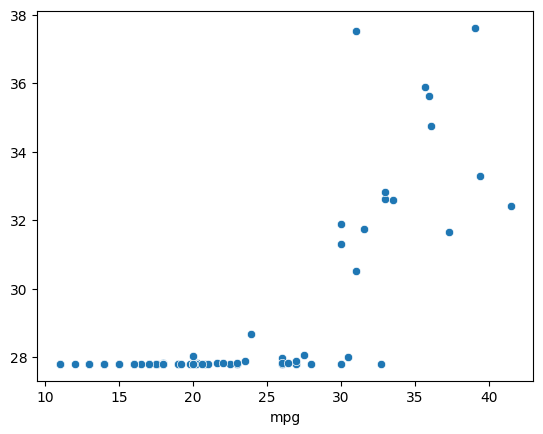

In [45]:
sns.scatterplot(x=y_test, y=y_pred)

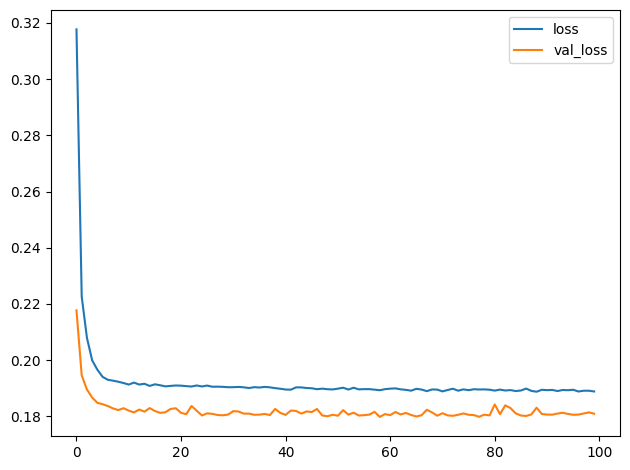

In [46]:
show_history_loss(history)

# ✅ Now we will try to fix the issue and replace sigmoid function with the correct one
* What function can we use? Why?

In [47]:
inp = keras.layers.Input(shape=(X_train.shape[1],))
norm = norm_layer(inp)
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='tanh')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,460 (21.33 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 19 (80.00 B)

## Train the model

In [48]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0772 - mean_absolute_error: 0.2098 - mean_absolute_percentage_error: 97.4646 - val_loss: 0.0323 - val_mean_absolute_error: 0.1430 - val_mean_absolute_percentage_error: 90.1215
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mean_absolute_error: 0.1066 - mean_absolute_percentage_error: 95.4779 - val_loss: 0.0309 - val_mean_absolute_error: 0.1369 - val_mean_absolute_percentage_error: 79.1756
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - mean_absolute_error: 0.1016 - mean_absolute_percentage_error: 79.0613 - val_loss: 0.0301 - val_mean_absolute_error: 0.1321 - val_mean_absolute_percentage_error: 91.2803
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - mean_absolute_error: 0.0996 - mean_absolute_percentage_error: 101.7327 - val_loss: 0.0261 - val_mean_absolute_error: 0.1217 - val_mean_absolute_percentage_error: 93.2080
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

In [49]:
model.load_weights("best.weights.h5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test_scaled, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,0.126798,0.02874,63.984696,46.84893,0.820852


## Now we can transfer the data back

In [50]:
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()
y_pred[:10]

array([18.859478, 20.019405, 13.125575, 12.088611, 23.185513, 23.103514,
       26.127752, 31.047062, 16.958822, 29.652725], dtype=float32)

In [51]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,2.383797,10.157726,10.632515,10.705694,0.820852


# Plot of the y_test vs. y_pred
* Is it better?

<Axes: xlabel='mpg'>

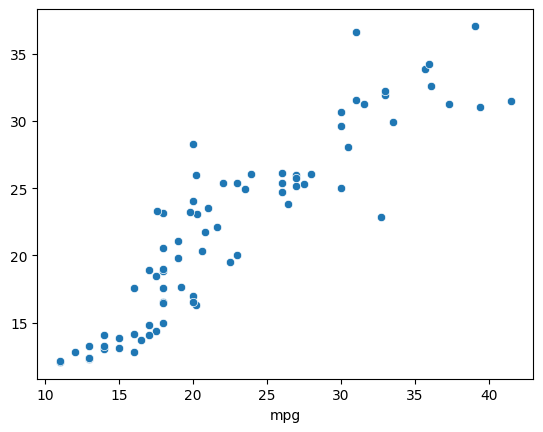

In [52]:
sns.scatterplot(x=y_test, y=y_pred)

## The convergence was quite fast
* We can see that there is an issue with the val_loss stability as the changes are very low now

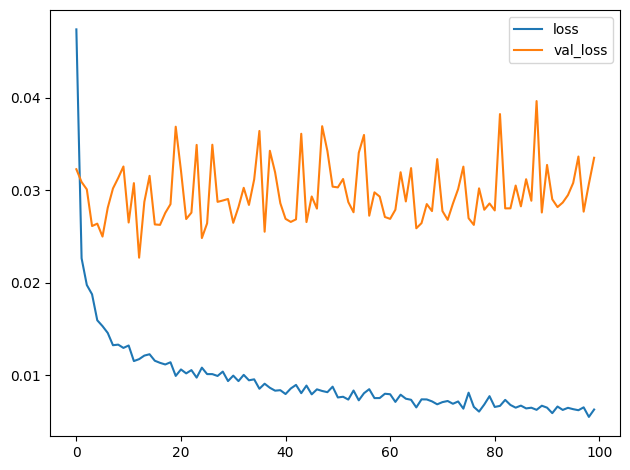

In [53]:
show_history_loss(history)

## ✅  Tasks for the lecture (2p)

1) Try to use [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) for the output values in a similar manner
as the MinMaxScaler - **(1p)**

    - When do we use it? Why?
    
    - If you wanted to guess if it helps, what do you think?
        * Plot histogram of the output (*mpg*), you can make an educated guess based on it 🙂
    
2) Try to design your own network and beat the **benchmark** network used in the lecture - **(1p)**

# Tasks

## Task 1

### Fit and transform the training data

In [54]:
power_transformer = PowerTransformer()
y_train_scaled = power_transformer.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()

### Transform the test data

In [55]:
y_test_scaled = power_transformer.transform(np.array(y_test).reshape((-1, 1))).ravel()

### Train the model with the scaled data

In [56]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [57]:
history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2527 - mean_absolute_error: 0.4025 - mean_absolute_percentage_error: 61.2550 - val_loss: 0.1654 - val_mean_absolute_error: 0.3208 - val_mean_absolute_percentage_error: 109.0574
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1569 - mean_absolute_error: 0.2950 - mean_absolute_percentage_error: 57.9946 - val_loss: 0.1630 - val_mean_absolute_error: 0.3260 - val_mean_absolute_percentage_error: 127.5387
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1781 - mean_absolute_error: 0.3122 - mean_absolute_percentage_error: 52.1010 - val_loss: 0.1589 - val_mean_absolute_error: 0.3106 - val_mean_absolute_percentage_error: 120.7691
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1544 - mean_absolute_error: 0.2850 - mean_absolute_percentage_error: 54.8772 - val_loss: 0.1530 - val_mean_absolute_error: 0.3022 - val_mean_absolute_percentage_error: 118.1585
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

### Load the best weights and make predictions

In [58]:
model.load_weights("best.weights.h5")
y_pred = model.predict(X_test).ravel()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


### Inverse transform the predictions

In [59]:
y_pred = power_transformer.inverse_transform(y_pred.reshape((-1, 1))).ravel()

### Evaluate the metrics

In [60]:
df_pred_powertransform = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
metrics = compute_metrics(df_pred_powertransform)
metrics

,MAE,MSE,MAPE,SMAPE,R2
0,2.612971,13.326115,12.259223,11.729481,0.764973


### Plot the results

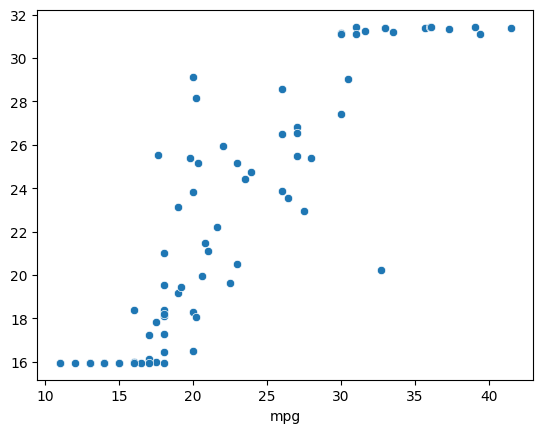

In [61]:
sns.scatterplot(x=y_test, y=y_pred)
plt.show()

- 🔄 PowerScaler was used, affecting value distribution.  
- 📊 The model captures the trend but has issues at the top.  
- 🚩 Predictions seem to hit an upper limit, causing flattening.  
- ⚠️ Possible scaling or model constraint problem.  

## Task 2


### 🚀 Improved Custom Model  

#### 🔧 Enhancements:  
##### 1. 🎯 **Normalization Layer**  
   - ✅ Ensures consistent feature scaling for stable training.  

##### 2. 🏗️ **Deeper Architecture**  
   - 🔢 Expanded layers (**256 → 128 → 64 → 32**) to capture complex patterns.  

##### 3. 🔄 **Dropout Regularization**  
   - 🚫 **Dropout (0.2)** after the first layer and **Dropout (0.1)** before the output layer.  
   - 🎲 Reduces overfitting by randomly deactivating neurons.  


In [62]:
def create_custom_model():
    inp = keras.layers.Input(shape=(X_train.shape[1],))
    norm = norm_layer(inp)

    hidden_1 = keras.layers.Dense(256, activation='relu')(norm)
    dropout_1 = keras.layers.Dropout(0.2)(hidden_1)

    hidden_2 = keras.layers.Dense(128, activation='relu')(dropout_1)
    hidden_3 = keras.layers.Dense(64, activation='relu')(hidden_2)

    hidden_4 = keras.layers.Dense(32, activation='relu')(hidden_3)
    dropout_2 = keras.layers.Dropout(0.1)(hidden_4)

    out = keras.layers.Dense(1, activation='linear')(dropout_2)

    model = keras.Model(inp, out)

    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])

    return model

In [63]:
custom_model = create_custom_model()
custom_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,844 (179.08 KB)

 Trainable params: 45,825 (179.00 KB)

 Non-trainable params: 19 (80.00 B)

### Train the custom model

In [64]:
history_custom = custom_model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.4645 - mean_absolute_error: 0.5018 - mean_absolute_percentage_error: 73.0440 - val_loss: 0.1377 - val_mean_absolute_error: 0.2878 - val_mean_absolute_percentage_error: 150.0373
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1424 - mean_absolute_error: 0.3009 - mean_absolute_percentage_error: 65.2285 - val_loss: 0.1863 - val_mean_absolute_error: 0.3444 - val_mean_absolute_percentage_error: 120.2024
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1364 - mean_absolute_error: 0.2850 - mean_absolute_percentage_error: 60.4045 - val_loss: 0.1410 - val_mean_absolute_error: 0.2944 - val_mean_absolute_percentage_error: 118.1611
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1197 - mean_absolute_error: 0.2612 - mean_absolute_percentage_error: 53.8128 - val_loss: 0.1828 - val_mean_absolute_error: 0.3304 - val_mean_absolute_percentage_error: 126.8359
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

### Load the best weights and make predictions

In [65]:
custom_model.load_weights("best.weights.h5")
y_pred_custom = custom_model.predict(X_test).ravel()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


### Inverse transform the predictions

In [66]:
y_pred_custom = power_transformer.inverse_transform(y_pred_custom.reshape((-1, 1))).ravel()

### Evaluate the metrics

#### Original model

#### Model with `PowerTransform`

In [69]:
compute_metrics(df_pred_powertransform)

,MAE,MSE,MAPE,SMAPE,R2
0,2.612971,13.326115,12.259223,11.729481,0.764973


#### Original model

In [67]:
compute_metrics(df_pred_origin)

,MAE,MSE,MAPE,SMAPE,R2
0,3.012321,16.065327,13.708837,13.80333,0.716662


#### Model with norm layer

In [68]:
compute_metrics(df_pred_origin_norm)

,MAE,MSE,MAPE,SMAPE,R2
0,2.195392,9.970854,9.787748,9.631657,0.824148


#### Customer better model


In [70]:
df_pred_custom = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_custom})
metrics_custom = compute_metrics(df_pred_custom)
metrics_custom

,MAE,MSE,MAPE,SMAPE,R2
0,2.126524,9.00209,9.404451,9.409538,0.841234


### Plot the results

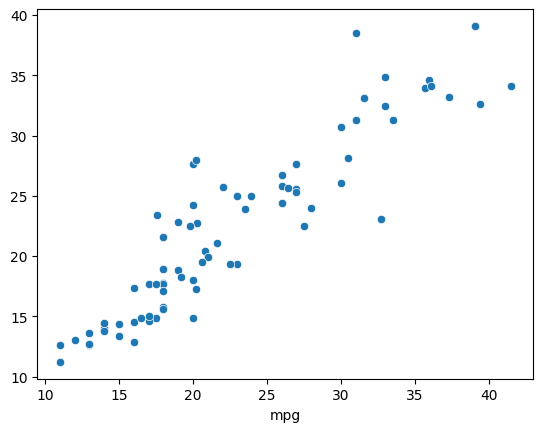

In [72]:
sns.scatterplot(x=y_test, y=y_pred_custom)
plt.show()

- 🔍 Shows how well the model's predictions match real data.  
- 📊 A positive trend suggests a decent fit.  
- ⚠️ Some scatter indicates prediction errors.  
- ✅ Overall, the model seems to capture the trend well!  